In [2]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
#from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

from pymoo.core.problem import Problem as PymooProblem
#from pymoo.core.termination import NoTermination

###########

# jmetalpy dependencies
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregative_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEADIEpsilon


###########

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

C:\Users\user\AppData\Local\Temp\ipykernel_63868\2817383456.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


In [ ]:
# fit the surrogate model
fit_gpytorch_model(mll)    

##########

# define the acqusition function for EIC if feas_weighting is false
acq_func = qNoisyExpectedHypervolumeImprovement(
    model=model,
    ref_point=-ref_point, # for computing HV, must flip for BoTorch
    X_baseline=train_x_gp, # feed total list of train_x for this current iteration
    sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
    objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
    constraints=create_idxrs(), # constraint on last n_constr col
    prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

##########

# propose candidates given defined qNEHVI acq func given model and latest observed training data
new_x, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds, # since train_x was normalized
                q=BATCH_SIZE, # no of candidates to propose in parallel
                num_restarts=2, # no of restarts of raw_samples
                raw_samples=256,  # pool of samples to choose the starting points from
                options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                )

# unormalize our training inputs back to original problem bounds
new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

# feed new proposed observations into objective func to get its new ground truth
new_obj, new_con = problem.evaluate(new_x)

# add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
new_con_noisy = new_con + noise*torch.randn_like(new_con)

# update training points by concatenating the new values into their respective tensors
train_x = torch.cat([train_x, new_x])
train_obj = torch.cat([train_obj, new_obj])
train_con = torch.cat([train_con, new_con])
train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

##########

##########

# update the surrogate models for next iteration
train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

In [ ]:
models = []
for i in range(train_y.shape[-1]):
    models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)

In [2]:
def optimize_qnehvi(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts of raw_samples
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])
        
        ##########
        
        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_con, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [3]:
def optimize_hybrid_nsga(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=problem.n_constr, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
       
        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, 256, seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        pop.set("G", train_con_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, nsga3_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [4]:
def optimize_hybrid_moead(problem, ref_point, initial_x, # must haves
                         N_BATCH, BATCH_SIZE, 
                         random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj
            self.number_of_constraints = problem.n_constr

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj, train_con = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    train_con_noisy = train_con + noise*torch.randn_like(train_con)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    
    ##########    
    
    def create_idxr(i):
        def idxr(Z):
            return Z[..., i]

        return idxr

    def create_idxrs():
        return [create_idxr(i=i) for i in range(problem.n_obj, problem.n_obj+problem.n_constr)]
    
    ########## ########## ########## start of iteration loop

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            constraints=create_idxrs(), # constraint on last n_constr col
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts if q candidates fail to show improvement
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
        
        max_pop = train_x_gp.shape[0]
        
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )
        
        
        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                      number_of_constraints=problem.n_constr,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            solution1.constraints = train_con_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
            
        moead_x = torch.tensor(offspring_population, **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y[:,:problem.n_obj])
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj, new_con = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)
        new_con_noisy = new_con + noise*torch.randn_like(new_con)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_con = torch.cat([train_con, new_con])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        train_con_noisy = torch.cat([train_con_noisy, new_con_noisy])

        # computing HV of current candidate list
        is_feas = (train_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
        feas_train_obj = train_obj[is_feas] # take only points that fit the 1st check
        if feas_train_obj.shape[0] > 0:
            pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
            pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
            volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        else:
            volume = 0.0

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = torch.cat([train_obj_noisy, train_con_noisy], dim=-1) # model takes noisy observations

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, new_con, qnehvi_x, moead_x, new_obj_noisy, new_con_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj, train_con]).cpu().numpy()

In [4]:
dimensions = 8

class MWBase(torch.nn.Module):   
    def g1(X, n_obj):
        d = dimensions
        n = d - n_obj

        z = torch.pow(X[..., n_obj - 1:], n)
        i = torch.arange(n_obj - 1, d, **tkwargs)

        exp = 1 - torch.exp(-10.0 * (z - 0.5 - i / (2 * d)) * (z - 0.5 - i / (2 * d)))
        distance = 1 + exp.sum(axis=1)
        return distance
    
    def g2(X, n_obj):
        d = dimensions
        n = d

        i = torch.arange(n_obj - 1, d, **tkwargs)
        z = 1 - torch.exp(-10.0 * (X[..., n_obj - 1:] - i / n) * (X[..., n_obj - 1:] - i / n))
        
        contrib = (0.1 / (n)) * z * z + 1.5 - 1.5 * torch.cos(2 * np.pi * z)
        distance = 1 + contrib.sum(axis=1)
        return distance
    
    def g3(X, n_obj):
        contrib = 2.0 * torch.pow(X[..., n_obj - 1:] + (X[..., n_obj - 2:-1] - 0.5) * (X[..., n_obj - 2:-1] - 0.5) - 1.0, 2.0)
        
        distance = 1 + contrib.sum(axis=1)
        return distance
    
    def LA1(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * np.pi * torch.pow(theta, C)), D)

    def LA2(A, B, C, D, theta):
        return A * torch.pow(torch.sin(B * torch.pow(theta, C)), D)

class Problem_MW10(torch.nn.Module):
    # must define these!
    n_var = dimensions
    n_obj = 2
    n_constr = 3 # inequality constraints only!
    
    ref_point = torch.tensor([1.5,1.5], **tkwargs)
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = MWBase.g2(X, n_obj=2)
        
        f0 = g * torch.pow(X[..., 0], dimensions)
        f1 = g * (1.0 - torch.pow(f0 / g, 2.0))
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        c1 = -1.0 * (2.0 - 4.0 * f0 * f0 - f1) * (2.0 - 8.0 * f0 * f0 - f1)
        c2 = (2.0 - 2.0 * f0 * f0 - f1) * (2.0 - 16.0 * f0 * f0 - f1)
        c3 = (1.0 - f0 * f0 - f1) * (1.2 - 1.2 * f0 * f0 - f1)     
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive, to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive, to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f0, -f1], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2, c3], dim=-1)
        
        return output, slack
    
class Problem_MW11(torch.nn.Module):
    # must define these!
    n_var = dimensions
    n_obj = 2
    n_constr = 4 # inequality constraints only!
    
    ref_point = torch.tensor([2.25,2.25], **tkwargs)
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    bounds[1] = np.sqrt(2)
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = MWBase.g3(X, n_obj=2)
        f0 = g * X[:, 0]
        f1 = g * torch.sqrt(2.0 - torch.pow(f0 / g, 2.0))
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        c1 = -1.0 * (3.0 - f0 * f0 - f1) * (3.0 - 2.0 * f0 * f0 - f1)
        c2 = (3.0 - 0.625 * f0 * f0 - f1) * (3.0 - 7.0 * f0 * f0 - f1)
        c3 = -1.0 * (1.62 - 0.18 * f0 * f0 - f1) * (1.125 - 0.125 * f0 * f0 - f1)
        c4 = (2.07 - 0.23 * f0 * f0 - f1) * (0.63 - 0.07 * f0 * f0 - f1)
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive, to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive, to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f0, -f1], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2, c3, c4], dim=-1)
        
        return output, slack        
        
    
class Problem_MW12(torch.nn.Module):
    # must define these!
    n_var = dimensions
    n_obj = 2
    n_constr = 2 # inequality constraints only!
    
    ref_point = torch.tensor([1.5,1.5], **tkwargs)
        
    # input bounds, don't forget to change according to n_var!  
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):
        
        # objectives are defined by f1, f2....
        # if you have complex equations, you can break it up and place them in ProblemBase for convenience, not compulsory
        # otherwise, you could place an oracle here that outputs the objective
        g = MWBase.g1(X, n_obj=2)
        f1 = g * X[:, 0]
        f2 = g * (0.85 - 0.8 * (f1 / g) - 0.08 *torch.abs(torch.sin(3.2 * torch.pi * (f1 / g))))
        
        # inequality constraints should take the form of c(n)<=0
        # for equality constraints, either use the equality constr argument, or rewrite into inequality form (preferred)
        c1 = -1.0 * (1 - 0.625 * f1 - f2 + 0.08 * torch.sin(2 * torch.pi * (f2 - f1 / 1.6))) * (1.4 - 0.875 * f1 - f2 + 0.08 * torch.sin(2 * torch.pi * (f2 / 1.4 - f1 / 1.6)))
        c2 = (1 - 0.8 * f1 - f2 + 0.08 * torch.sin(2 * torch.pi * (f2 - f1 / 1.5))) * (1.8 - 1.125 * f1 - f2 + 0.08 * torch.sin(2 * torch.pi * (f2 / 1.8 - f1 / 1.6)))
        
        # botorch assumes maximisation
        # to maximise a postive output, stay positive, to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive, to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        slack = torch.stack([c1, c2], dim=-1)
        
        return output, slack


diff1 = 0.75
diff2 = 0.75
diff3 = 0.75    
    
class Problem_DAS1(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 11
    bounds = torch.stack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    # this will change depending on difficulty triplet
    # check the actual PF from pymoo to find
    ref_point = torch.tensor([1.6,1.6], **tkwargs)
    
    def evaluate(X):
        g = torch.zeros(X.shape[0], **tkwargs)
        for i in range(X.shape[1]):
            g += torch.pow(X[...,i] - torch.sin(0.5 * np.pi * X[...,0]), 2)

        f1 = X[...,0] + g
        f2 = 1.0 - torch.pow(X[...,0], 2) + g
        
        #################
        
        a = 20
        b = 2 * diff1 - 1.
        d = 0.5 if diff2 != 0 else 0
        if diff2 > 0:
            e = d - torch.log(torch.tensor(diff2, **tkwargs))
        else:
            e = 1e30
        r = 0.5 * diff3

        p_k = [0., 1.0, 0., 1.0, 2.0, 0., 1.0, 2.0, 3.0]
        q_k = [1.5, 0.5, 2.5, 1.5, 0.5, 3.5, 2.5, 1.5, 0.5]

        a_k2 = 0.3
        b_k2 = 1.2
        theta_k = torch.tensor(-0.25 * torch.pi, **tkwargs)

        c = torch.zeros((X.shape[0], 11), **tkwargs)

        c[...,0] = torch.sin(a * torch.pi * X[...,0]) - b

        if diff2 == 1:
            c[...,1] = 1e-4 - torch.abs(e - g, **tkwargs)
        else:
            c[...,1] = (e - g) * (g - d)

        for i in range(2, 11):
            c[...,i] = ((f1 - p_k[i-2]) * torch.cos(theta_k) - (f2 - q_k[i-2]) * torch.sin(theta_k)) ** 2 / a_k2 + ((f1 - p_k[i-2]) * torch.sin(theta_k) + (f2 - q_k[i-2]) * torch.cos(theta_k)) ** 2 / b_k2 - r


        ####################
        
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f1, -f2], dim=-1)
        
        # constraint equations should take the form of c(n)<=0
        # should return <=0 values when constraints are active,
        # and >0 values when constraints are violated
        slack = -c    
        
        return output, slack

class Problem_DAS9(torch.nn.Module):
    n_var = dimensions
    n_obj = 3
    n_constr = 7
    bounds = torch.stack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    # this will change depending on difficulty triplet
    # check the actual PF from pymoo to find
    ref_point = torch.tensor([1.6,1.6,1.6], **tkwargs)
    
    def evaluate(X):
        
        j = torch.arange(3 - 1, dimensions, **tkwargs) + 1
        contrib = (X[:, 3 - 1:] - torch.cos(0.25 * j / dimensions * torch.pi * (X[:, 0:1] + X[:, 1:2]))) ** 2
        g = contrib.sum(axis=1)[:, None]
        
        f0 = torch.cos(0.5 * torch.pi * X[:, 0:1]) * torch.cos(0.5 * torch.pi * X[:, 1:2]) + g
        f1 = torch.cos(0.5 * torch.pi * X[:, 0:1]) * torch.sin(0.5 * torch.pi * X[:, 1:2]) + g
        f2 = torch.sin(0.5 * torch.pi * X[:, 0:1]) + g    
        
        #################
        
        a = 20.
        b = 2. * diff1 - 1.
        d = 0.5 if diff2 != 0 else 0
        if diff2 > 0:
            e = d - np.log(diff2)
        else:
            e = 1e30
        r = 0.5 * diff3

        x_k = torch.tensor([[1.0, 0., 0., 1.0 / np.sqrt(3.0)]], **tkwargs)
        y_k = torch.tensor([[0., 1.0, 0., 1.0 / np.sqrt(3.0)]], **tkwargs)
        z_k = torch.tensor([[0., 0., 1.0, 1.0 / np.sqrt(3.0)]], **tkwargs)

        c = torch.zeros((X.shape[0], 3 + x_k.shape[1]), **tkwargs)

        c[:, 0] = torch.sin(a * torch.pi * X[:, 0]) - b
        c[:, 1] = torch.cos(a * torch.pi * X[:, 1]) - b
        if diff2 == 1:
            c[:, 2:3] = 1e-4 - np.abs(e - g)
        else:
            c[:, 2:3] = (e - g) * (g - d)

        c[:, 3:] = (f0 - x_k) ** 2 + (f1 - y_k) ** 2 + (f2 - z_k) ** 2 - r ** 2
        
        ####################
        
        # to maximise a postive output, stay positive
        # to minimise a positive output, force negative
        # to maximise a negative output (away from zero), force positive
        # to minimise a negative output (towards zero), stay negative
        output = torch.stack([-f0, -f1, -f2], dim=-1).squeeze(1)
        
        # constraint equations should take the form of c(n)<=0
        # should return <=0 values when constraints are active,
        # and >0 values when constraints are violated
        slack = -c    
        
        return output, slack

'''
pymooproblem = get_problem("mw11")
torchproblem = Problem_MW11
initial_x = draw_sobol_samples(bounds=torchproblem.bounds,n=1, q=4, seed=1).squeeze(0)
pymooproblem.evaluate(initial_x.cpu().numpy())
torchproblem.evaluate(initial_x)

initial_x_array = loadtxt("initial_x_10trials8dim_0tosqrt2bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 18, 8)

'''    

initial_x_array = loadtxt("initial_x_10trials8dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 18, 8)

In [6]:
problem = Problem_MW11
problemname = "MW11"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 4

hvs_qnehvi = []
train_qnehvi = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_qnehvi(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_qnehvi.append(hv)
    train_qnehvi.append(train)
    
    
savetxt(f"{problemname}_hvs_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_qnehvi, delimiter=',')    
savetxt(f"{problemname}_train_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_qnehvi).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW11 with d = 8
Optimizing with Pure qNEHVI


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 0.00, time = 20.73s.


InputDataError: Input data contains NaN values.

In [6]:
problem = Problem_MW11
problemname = "MW11"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_hybrid_nsga = []
train_hybrid_nsga = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_hybrid_nsga(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_hybrid_nsga.append(hv)
    train_hybrid_nsga.append(train)
    
    
savetxt(f"{problemname}_hvs_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_hybrid_nsga, delimiter=',')    
savetxt(f"{problemname}_train_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_hybrid_nsga).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW5 with d = 8
Optimizing with Hybrid qNEHVI + U-NSGA-III


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 0.00, time = 11.30s.
Batch  2 of 24: Hypervolume = 0.00, time = 44.45s.
Batch  3 of 24: Hypervolume = 0.00, time = 34.76s.
Batch  4 of 24: Hypervolume = 0.00, time = 33.81s.
Batch  5 of 24: Hypervolume = 0.00, time = 15.00s.
Batch  6 of 24: Hypervolume = 0.13, time = 12.21s.
Batch  7 of 24: Hypervolume = 0.22, time = 25.74s.
Batch  8 of 24: Hypervolume = 0.22, time = 29.85s.
Batch  9 of 24: Hypervolume = 0.28, time = 17.30s.
Batch 10 of 24: Hypervolume = 0.30, time = 17.72s.
Batch 11 of 24: Hypervolume = 0.32, time = 32.40s.
Batch 12 of 24: Hypervolume = 0.32, time = 13.72s.
Batch 13 of 24: Hypervolume = 0.32, time = 19.12s.
Batch 14 of 24: Hypervolume = 0.40, time = 20.05s.
Batch 15 of 24: Hypervolume = 0.41, time = 15.37s.
Batch 16 of 24: Hypervolume = 0.48, time = 21.44s.
Batch 17 of 24: Hypervolume = 0.50, time = 30.52s.
Batch 18 of 24: Hypervolume = 0.51, time = 22.09s.
Batch 19 of 24: Hypervolume = 0.51, time = 11.93s.
Batch 20 of 24: Hypervolume = 0

Batch  5 of 24: Hypervolume = 0.18, time = 19.98s.
Batch  6 of 24: Hypervolume = 0.19, time = 19.05s.
Batch  7 of 24: Hypervolume = 0.24, time = 30.58s.
Batch  8 of 24: Hypervolume = 0.25, time = 11.99s.
Batch  9 of 24: Hypervolume = 0.28, time = 35.76s.
Batch 10 of 24: Hypervolume = 0.30, time = 13.72s.
Batch 11 of 24: Hypervolume = 0.30, time = 29.23s.
Batch 12 of 24: Hypervolume = 0.30, time = 22.25s.
Batch 13 of 24: Hypervolume = 0.30, time = 20.50s.
Batch 14 of 24: Hypervolume = 0.37, time = 17.30s.
Batch 15 of 24: Hypervolume = 0.38, time = 11.77s.
Batch 16 of 24: Hypervolume = 0.44, time = 18.83s.
Batch 17 of 24: Hypervolume = 0.46, time = 21.40s.
Batch 18 of 24: Hypervolume = 0.46, time = 28.88s.
Batch 19 of 24: Hypervolume = 0.49, time = 20.45s.
Batch 20 of 24: Hypervolume = 0.50, time = 12.49s.
Batch 21 of 24: Hypervolume = 0.50, time = 11.01s.
Batch 22 of 24: Hypervolume = 0.50, time = 16.76s.
Batch 23 of 24: Hypervolume = 0.50, time = 15.59s.
Batch 24 of 24: Hypervolume = 0

In [7]:
problem = Problem_MW11
problemname = "MW11"

N_TRIALS = 10
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

hvs_hybrid_moead = []
train_hybrid_moead = []

# main loop for each trial/run, random_state will be trial number
for trial in range(0, N_TRIALS):
    print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

    # initialize with a 2*(d+1) sample set
    initial_x = torch.tensor(initial_x_array[trial], **tkwargs)
    
    hv, train = optimize_hybrid_moead(problem, problem.ref_point, initial_x,
                     N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                     random_state=trial, noise=noise, verbose=verbose)
    hvs_hybrid_moead.append(hv)
    train_hybrid_moead.append(train)
    
    
savetxt(f"{problemname}_hvs_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hvs_hybrid_moead, delimiter=',')    
savetxt(f"{problemname}_train_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_hybrid_moead).reshape(-1), delimiter=',')

print("ALL DONE!")


Trial  1 of 10 for problem MW7 with d = 8
Optimizing with Hybrid qNEHVI + MOEAD
Batch  1 of 24: Hypervolume = 0.00, time = 19.23s.
Batch  2 of 24: Hypervolume = 0.12, time = 23.74s.
Batch  3 of 24: Hypervolume = 0.12, time = 35.95s.
Batch  4 of 24: Hypervolume = 0.23, time = 10.02s.
Batch  5 of 24: Hypervolume = 0.27, time = 29.69s.
Batch  6 of 24: Hypervolume = 0.29, time = 8.06s.
Batch  7 of 24: Hypervolume = 0.32, time = 38.65s.
Batch  8 of 24: Hypervolume = 0.32, time = 25.79s.
Batch  9 of 24: Hypervolume = 0.35, time = 15.87s.
Batch 10 of 24: Hypervolume = 0.36, time = 28.12s.
Batch 11 of 24: Hypervolume = 0.36, time = 16.61s.
Batch 12 of 24: Hypervolume = 0.39, time = 11.10s.
Batch 13 of 24: Hypervolume = 0.39, time = 7.45s.
Batch 14 of 24: Hypervolume = 0.41, time = 35.16s.
Batch 15 of 24: Hypervolume = 0.41, time = 10.39s.
Batch 16 of 24: Hypervolume = 0.41, time = 21.72s.
Batch 17 of 24: Hypervolume = 0.41, time = 29.27s.
Batch 18 of 24: Hypervolume = 0.41, time = 26.67s.
Bat

Batch  4 of 24: Hypervolume = 0.17, time = 20.08s.
Batch  5 of 24: Hypervolume = 0.19, time = 17.36s.
Batch  6 of 24: Hypervolume = 0.20, time = 13.20s.
Batch  7 of 24: Hypervolume = 0.25, time = 16.34s.
Batch  8 of 24: Hypervolume = 0.26, time = 26.14s.
Batch  9 of 24: Hypervolume = 0.26, time = 18.65s.
Batch 10 of 24: Hypervolume = 0.35, time = 17.10s.
Batch 11 of 24: Hypervolume = 0.36, time = 12.63s.
Batch 12 of 24: Hypervolume = 0.36, time = 12.46s.
Batch 13 of 24: Hypervolume = 0.37, time = 13.91s.
Batch 14 of 24: Hypervolume = 0.37, time = 13.20s.
Batch 15 of 24: Hypervolume = 0.37, time = 8.35s.
Batch 16 of 24: Hypervolume = 0.39, time = 28.02s.
Batch 17 of 24: Hypervolume = 0.39, time = 11.29s.
Batch 18 of 24: Hypervolume = 0.40, time = 11.30s.
Batch 19 of 24: Hypervolume = 0.40, time = 27.32s.
Batch 20 of 24: Hypervolume = 0.40, time = 15.67s.
Batch 21 of 24: Hypervolume = 0.40, time = 30.09s.
Batch 22 of 24: Hypervolume = 0.41, time = 8.21s.
Batch 23 of 24: Hypervolume = 0.4

In [28]:
from pymoo.problems import get_problem
pf = get_problem("dascmop9", 12).pareto_front()
ref_point = torch.tensor([1.6,1.6, 1.6], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
volume = hv.compute(torch.tensor(-pf, **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.6, 1.6, 1.6], DAS9 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [1.6, 1.6, 1.6], DAS9 has a max HV of 0.7615189768385432


In [29]:
from pymoo.problems import get_problem
pf = get_problem("mw10").pareto_front()
ref_point = torch.tensor([1.5,1.5], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
volume = hv.compute(torch.tensor(-pf, **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.55, 1.5], MW10 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [1.55, 1.5], MW10 has a max HV of 1.4464980596163968


[Text(108.125, 0.5, 'Log Hypervolume Difference')]

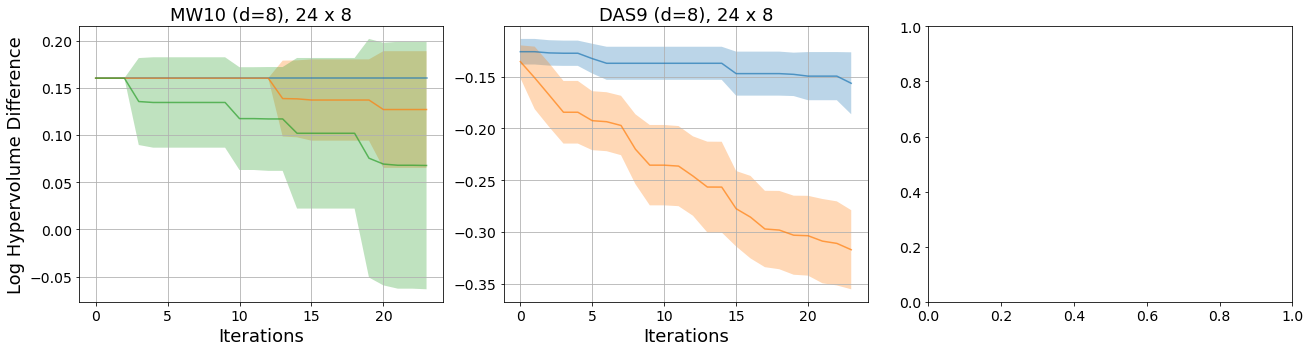

In [31]:
N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

problemname = 'MW10'
max_hv = 1.4464980596163968
idx = 0

for algo_name, plot_name, in zip(
    ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
    ['qNEHVI', 'EGBO (U-NSGA=III)', 'EGBO (MOEA/D-IEpsilon)']):

    hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_plot = np.log10(max_hv - np.asarray(hv_list))

    ax[idx].plot(np.arange(N_BATCH),
            hv_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax[idx].fill_between(np.arange(N_BATCH),
                    hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                    alpha=0.3)

    ax[idx].set(xlabel='Iterations')
    ax[idx].grid(True)
    ax[idx].set_title(f"{problemname} (d=8), {N_BATCH} x {BATCH_SIZE}", fontsize=18)
    
problemname = 'DAS9'
max_hv = 0.7615189768385432
idx = 1

for algo_name, plot_name, in zip(
    ['qnehvi', 'hybrid_nsga'],
    ['qNEHVI', 'EGBO (U-NSGA=III)']):

    hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_plot = np.log10(max_hv - np.asarray(hv_list))

    ax[idx].plot(np.arange(N_BATCH),
            hv_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax[idx].fill_between(np.arange(N_BATCH),
                    hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                    alpha=0.3)

    ax[idx].set(xlabel='Iterations')
    ax[idx].grid(True)
    ax[idx].set_title(f"{problemname} (d=8), {N_BATCH} x {BATCH_SIZE}", fontsize=18)    

fig.tight_layout()        
ax[0].set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

FileNotFoundError: DAS9_hvs_hybrid_moead_24by8_10trials.csv not found.

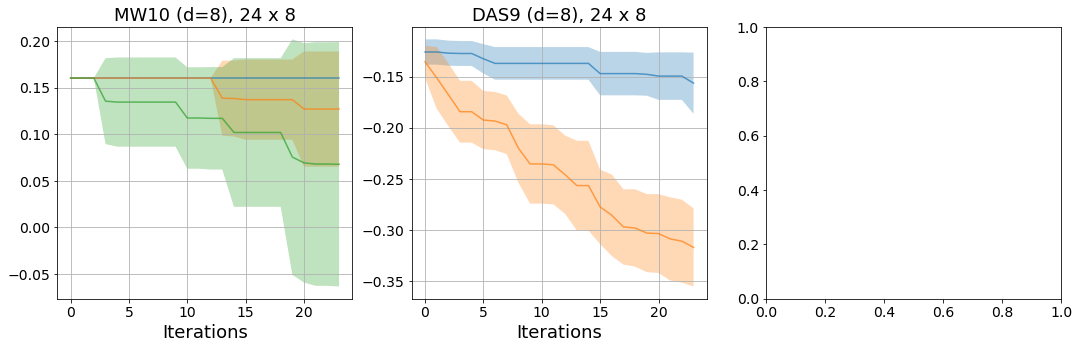

In [30]:
N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problemname, max_hv, idx in zip(
    ['MW10', 'DAS9', 'MW10'],
    [1.4464980596163968, 0.7615189768385432, 0.5039622081235824],
    [0, 1, 2]):

    for algo_name, plot_name, in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['qNEHVI', 'EGBO (U-NSGA=III)', 'EGBO (MOEA/D-IEpsilon)']):

        hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot = np.log10(max_hv - np.asarray(hv_list))

        ax[idx].plot(np.arange(N_BATCH),
                hv_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                        alpha=0.3)
    
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{problemname} (d=8), {N_BATCH} x {BATCH_SIZE}", fontsize=18)

fig.tight_layout()        
ax[0].set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

In [18]:
problem = Problem_DAS9
problemname = 'DAS9'

from pymoo.problems import get_problem
pf = get_problem("dascmop9", 12).pareto_front()

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10  

xlist, ylist, zlist = [], [], []

algo_name = 'qnehvi'
    
train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

hv1 = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    

for trial in range(N_TRIALS):

    xlist.append(train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
    ylist.append(train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])
    zlist.append(train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,2])

x1 = np.array(xlist).reshape(-1)
y1 = np.array(ylist).reshape(-1)
z1 = np.array(zlist).reshape(-1)

xyz1 = np.vstack([x1,y1,z1])
zz1 = gaussian_kde(xyz1)(xyz1)
idx1 = zz1.argsort()
x1, y1, z1, zz1 = x1[idx1], y1[idx1], z1[idx1], zz1[idx1]

#######

algo_name = 'hybrid_nsga'
    
train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
hv2 = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    
xlist, ylist, zlist = [], [], []

for trial in range(N_TRIALS):

    xlist.append(train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
    ylist.append(train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])
    zlist.append(train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,2])

x2 = np.array(xlist).reshape(-1)
y2 = np.array(ylist).reshape(-1)
z2 = np.array(zlist).reshape(-1)

xyz2 = np.vstack([x2,y2,z2])
zz2 = gaussian_kde(xyz2)(xyz2)
idx2 = zz2.argsort()
x2, y2, z2, zz2 = x2[idx2], y2[idx2], z2[idx2], zz2[idx2]

#######

norm = plt.Normalize(min(np.array(zz1).min(), np.array(zz2).min()), max(np.array(zz1).max(), np.array(zz2).max()))

Text(0.5, 1.0, 'PDF')

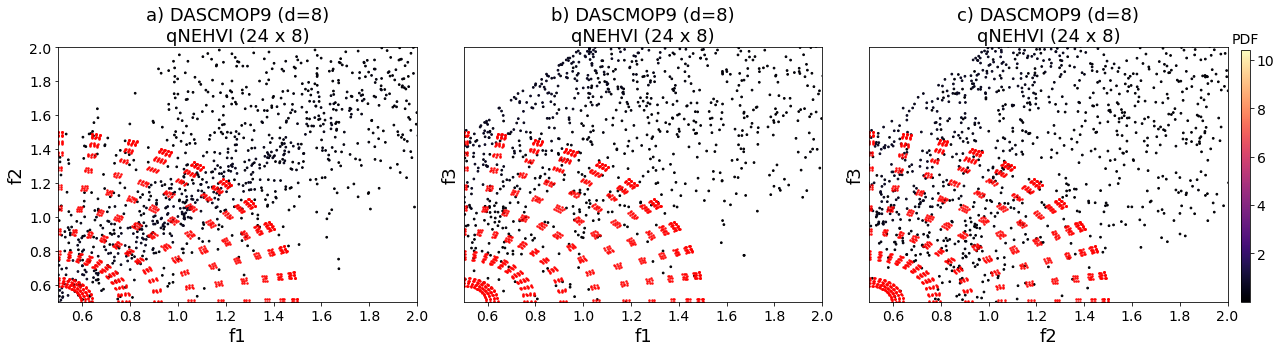

In [21]:
problemname = 'DASCMOP9'
plotname = 'qNEHVI'

fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

for subchoice1, subchoice2, plotchoice1, plotchoice2, i, subsub in zip(
    [x1, x1, y1], [y1, z1, z1],
    ['f1', 'f1', 'f2'], ['f2', 'f3', 'f3'],
    [0, 1, 2],
    ['a', 'b', 'c']):
    

    ax[i].scatter(-subchoice1, -subchoice2, c=zz1, s=3, norm=norm, cmap='magma')
    
    ax[i].scatter(pf[:,0],
                  pf[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)    
    
    #ax[i].text(1.5, 0.15, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"{subsub}) {problemname} (d={dimensions})\n{plotname} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(0.5, 2.0)
    ax[i].set_ylim(0.5, 2.0)
    
    ax[i].set_xlabel(plotchoice1)
    ax[i].set_ylabel(plotchoice2)
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

Text(0.5, 1.0, 'PDF')

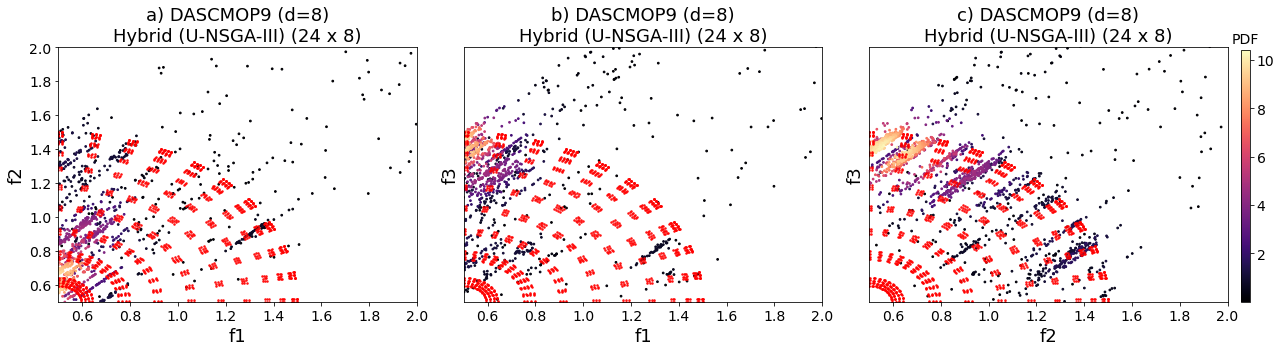

In [22]:
problemname = 'DASCMOP9'
plotname = 'Hybrid (U-NSGA-III)'

fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

for subchoice1, subchoice2, plotchoice1, plotchoice2, i, subsub in zip(
    [x2, x2, y2], [y2, z2, z2],
    ['f1', 'f1', 'f2'], ['f2', 'f3', 'f3'],
    [0, 1, 2],
    ['a', 'b', 'c']):
    

    ax[i].scatter(-subchoice1, -subchoice2, c=zz2, s=3, norm=norm, cmap='magma')
    
    ax[i].scatter(pf[:,0],
                  pf[:,1], 
                  c="r", s=10, marker=".", alpha=0.8)    
    
    #ax[i].text(1.5, 0.15, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"{subsub}) {problemname} (d={dimensions})\n{plotname} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(0.5, 2.0)
    ax[i].set_ylim(0.5, 2.0)
    
    ax[i].set_xlabel(plotchoice1)
    ax[i].set_ylabel(plotchoice2)
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

In [32]:
%matplotlib notebook

In [47]:
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels

<IPython.core.display.Javascript object>


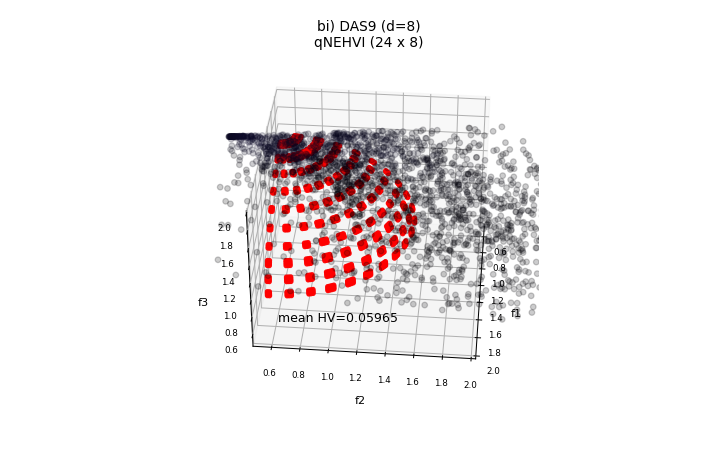

In [50]:
plot_name = 'qNEHVI'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(-x1, -y1, -z1, c=zz1, s=20, norm=norm, cmap='magma', alpha=0.2)
ax.scatter3D(pf[...,0], pf[...,1], pf[...,2], c='r', s=10, alpha=0.9)

ax.text(2, 0.65, 0.75, f"mean HV={hv1.mean(axis=0)[-1]:.5f}", fontsize=10)

ax.set_title(f"bi) {problemname} (d={problem.n_var})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=11)

ax.set_xlabel('f1', fontsize=9)
ax.set_ylabel('f2', fontsize=9)
ax.set_zlabel('f3', fontsize=9)

ax.set_xlim(0.5, 2.0)
ax.set_ylim(0.5, 2.0)
ax.set_zlim(0.5, 2.0)

ax.view_init(36, 5)

<IPython.core.display.Javascript object>


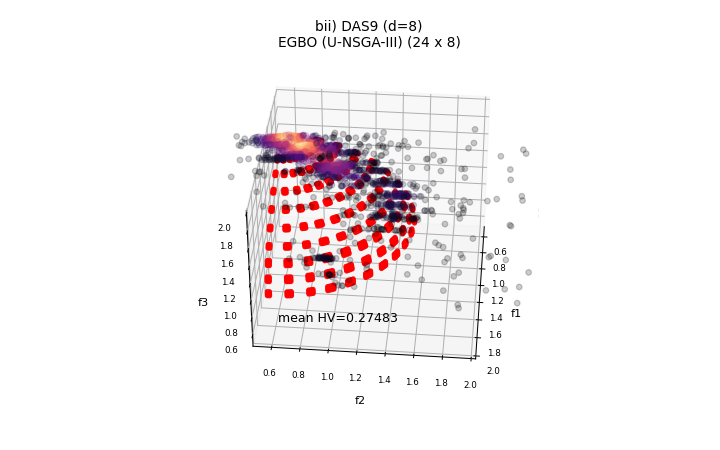

In [51]:
plot_name = 'EGBO (U-NSGA-III)'

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(-x2, -y2, -z2, c=zz2, s=20, norm=norm, cmap='magma', alpha=0.2)
ax.scatter3D(pf[...,0], pf[...,1], pf[...,2], c='r', s=10, alpha=0.9)

ax.text(2, 0.65, 0.75, f"mean HV={hv2.mean(axis=0)[-1]:.5f}", fontsize=10)

ax.set_title(f"bii) {problemname} (d={problem.n_var})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=11)

ax.set_xlabel('f1', fontsize=9)
ax.set_ylabel('f2', fontsize=9)
ax.set_zlabel('f3', fontsize=9)

ax.set_xlim(0.5, 2.0)
ax.set_ylim(0.5, 2.0)
ax.set_zlim(0.5, 2.0)

ax.view_init(36, 5)

In [93]:
zz1

array([0.007, 0.008, 0.008, ..., 0.851, 0.857, 0.862])

<IPython.core.display.Javascript object>


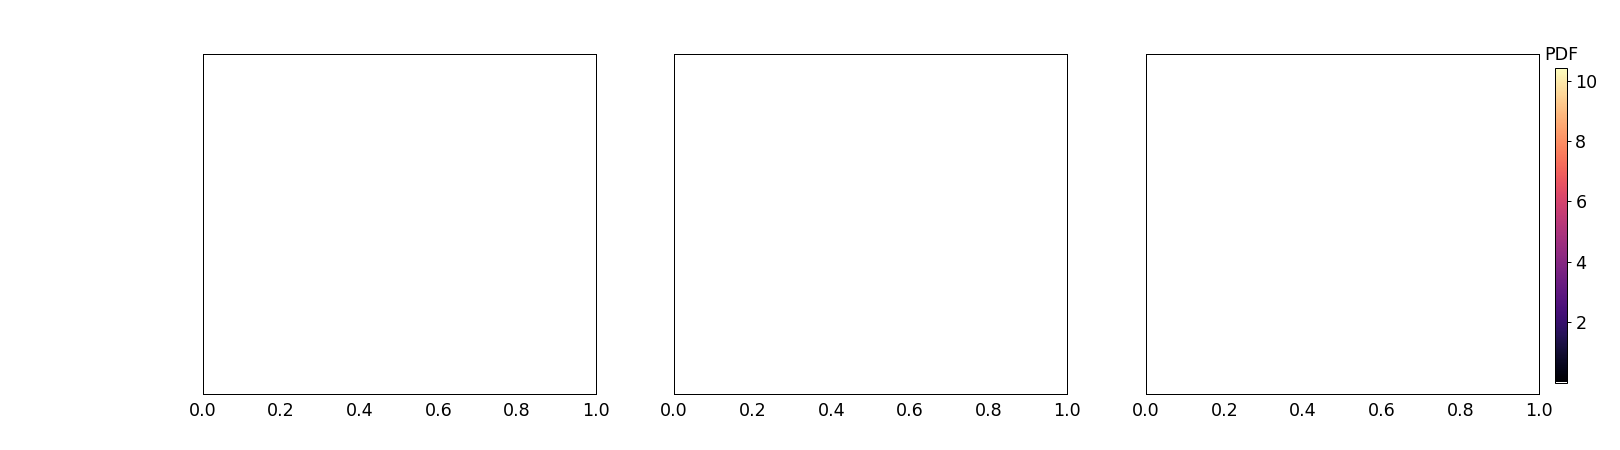

Text(0.5, 1.0, 'PDF')

In [105]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))
for i in range(0,3):
    ax[i].tick_params(axis='x', which='both', bottom=False, labelleft=False)
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

norm = plt.Normalize(min(zz1.min(), zz2.min()), max(zz1.max(), zz2.max()))

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

FileNotFoundError: MW3_hvs_hybrid_nsga_24by8_10trials.csv not found.

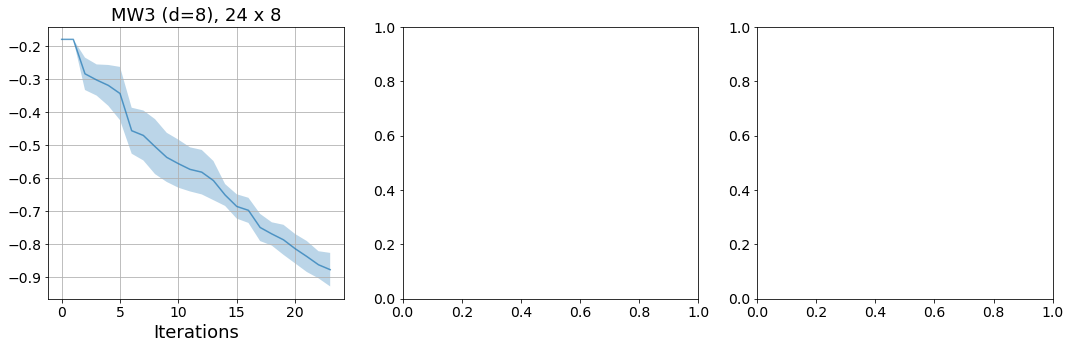

In [7]:
problemname = "ZDT1"
max_hv = 120.66140936892067

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 10

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problemname, max_hv, idx in zip(
    ['MW3', 'MW5', 'MW7'],
    [0.6607563181459482, 0.6229275708817372, 0.5039622081235824],
    [0, 1, 2]):

    for algo_name, plot_name, in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):

        hv_list = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot = np.log10(max_hv - np.asarray(hv_list))

        ax[idx].plot(np.arange(N_BATCH),
                hv_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        hv_plot.mean(axis=0)-ci(hv_plot, N_TRIALS), hv_plot.mean(axis=0)+ci(hv_plot, N_TRIALS),
                        alpha=0.3)
    
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{problemname} (d=8), {N_BATCH} x {BATCH_SIZE}", fontsize=18)

fig.tight_layout()        
ax[0].set(ylabel='Log Hypervolume Difference')
#ax.legend(loc='lower left')

In [ ]:
handles,labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, labels, loc='center', scatterpoints = 1)
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
axi.axis("off")
fig_legend.canvas.draw()
fig_legend.show()

[Text(0, 0.5, 'Cumltv Hypervolume Wastage')]

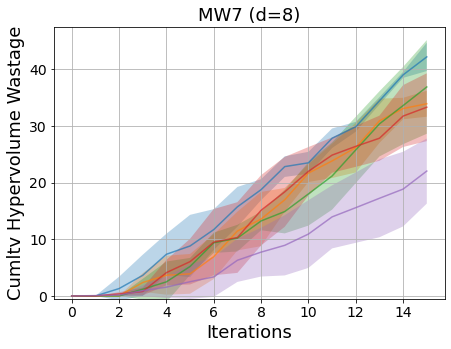

In [13]:
problem = Problem_MW7
problemname = "MW7"

N_BATCH = 16
BATCH_SIZE = 8
N_TRIALS = 3

ref_point = problem.ref_point
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

basedict = {}
a = 0
b = 2*(problem.n_var+1)-1
for i in range(0, N_BATCH+1):

    basedict[i] = (a, b)
    # a stays at zero
    b+=BATCH_SIZE
    
newdict = {}
a = 2*(problem.n_var+1)
b = 2*(problem.n_var+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE
    
fig, ax = plt.subplots(1, 1, figsize=(7, 5))    
    
for algo_name, plot_name, in zip(
    ['qnehvi', 'parallel_nsga', 'parallel_moead', 'hybrid_nsga', 'hybrid_moead'],
    ['Pure BO', 'Parallel w/ NSGA', 'Parallel w/ MOEAD', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD'],):
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

    hv_diff_list = []
    
    for trial in range(0, N_TRIALS):
        train_obj = torch.tensor(-train[trial][:,-problem.n_constr-problem.n_obj:-problem.n_constr], **tkwargs)
        train_con = torch.tensor(train[trial][:,-problem.n_constr:], **tkwargs)

        hv_diff_inner_list = []
        placeholder = 0

        for i in range(0, N_BATCH):
            base_obj = train_obj[basedict[i][0]:basedict[i][1]]
            base_con = train_con[basedict[i][0]:basedict[i][1]]

            is_feas = (base_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
            feas_train_obj = base_obj[is_feas] # take only points that fit the 1st check
            if feas_train_obj.shape[0] > 0:
                pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
                pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
                base_volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
            else:
                base_volume = 0.0

            new_obj = train_obj[newdict[i][0]:newdict[i][1]]
            new_con = train_con[newdict[i][0]:newdict[i][1]]

            is_feas = (new_con <= 0).all(dim=-1) # check whether points fit ALL (.all) constraint criteria
            feas_train_obj = new_obj[is_feas] # take only points that fit the 1st check
            if feas_train_obj.shape[0] > 0:
                pareto_mask = is_non_dominated(feas_train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
                pareto_y = feas_train_obj[pareto_mask] # take only points that fit the 2nd check
                new_volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
            else:
                new_volume = 0.0

            hv_diff = base_volume - new_volume

            if hv_diff > 0:
                placeholder += hv_diff
                hv_diff_inner_list.append(placeholder)
            else:
                hv_diff_inner_list.append(placeholder) 

        hv_diff_list.append(hv_diff_inner_list)
        
    hv_diff_plot = np.asarray(hv_diff_list)

    ax.plot(np.arange(N_BATCH),
            hv_diff_plot.mean(axis=0),
            label=f'{plot_name}', linewidth=1.5, alpha=0.7)

    ax.fill_between(np.arange(N_BATCH),
                    hv_diff_plot.mean(axis=0)-ci(hv_diff_plot, N_TRIALS), hv_diff_plot.mean(axis=0)+ci(hv_diff_plot, N_TRIALS),
                    alpha=0.3)
    
ax.set_ylim(-0.5)

ax.set(xlabel='Iterations')
ax.grid(True)
ax.set_title(f"{problemname} (d=8)", fontsize=18)
ax.set(ylabel='Cumltv Hypervolume Wastage')
#ax.legend(loc='best')

[Text(133.25, 0.5, 'Feasibility Achievement')]

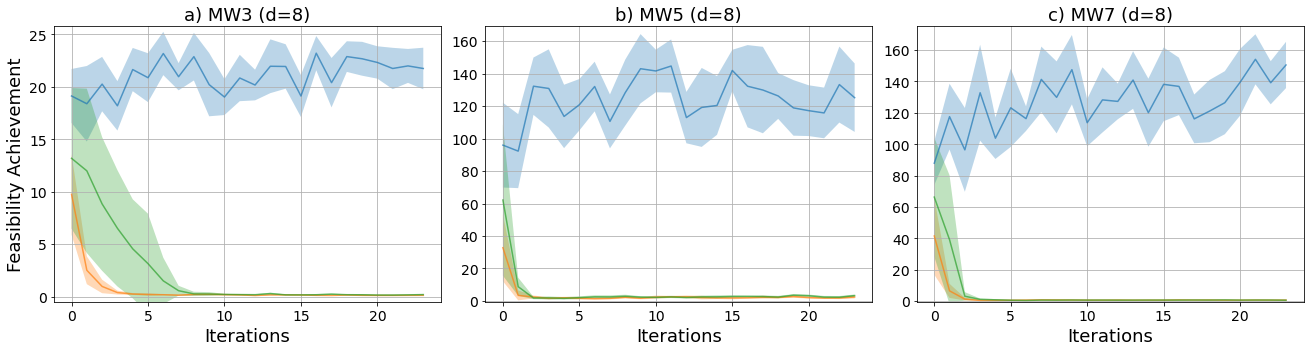

In [16]:
N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8
   
newdict = {}
a = 2*(8+1)
b = 2*(8+1)+BATCH_SIZE-1
for i in range(0, N_BATCH):

    newdict[i] = (a, b)
    a+=BATCH_SIZE
    b+=BATCH_SIZE  

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for problemname, problem, idx, sub in zip(
    ['MW3', 'MW5', 'MW7'],
    [Problem_MW3, Problem_MW5, Problem_MW7],
    [0, 1, 2],
    ['a', 'b', 'c']):

    for algo_name, plot_name, in zip(
        ['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
        ['Pure BO', 'Hybrid w/ NSGA', 'Hybrid w/ MOEAD']):
    
        train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)

        feas_list = []
        for trial in range(N_TRIALS):
            train_con = torch.tensor(train[trial][:,-problem.n_constr:], **tkwargs)
            for row in range(0, train_con.shape[0]):
                for col in range(0, train_con.shape[1]):
                    if train_con[row,col]<=0:
                        train_con[row,col]=0

            feas_combined = train_con.sum(dim=1)
            feas_value = feas_combined

            feas_list_inner = []
            for i in range(N_BATCH):
                feas_list_inner.append(feas_value[newdict[i][0]:newdict[i][1]].sum().cpu().numpy())

            feas_list.append(feas_list_inner)


        feas_plot = np.array(feas_list)    

        ax[idx].plot(np.arange(N_BATCH),
                feas_plot.mean(axis=0),
                label=f'{plot_name}', linewidth=1.5, alpha=0.7)

        ax[idx].fill_between(np.arange(N_BATCH),
                        feas_plot.mean(axis=0)-ci(feas_plot, N_TRIALS), feas_plot.mean(axis=0)+ci(feas_plot, N_TRIALS),
                        alpha=0.3)
 
        ax[idx].set_ylim(-0.5, None)
        ax[idx].set(xlabel='Iterations')
        ax[idx].grid(True)
        ax[idx].set_title(f"{sub}) {problemname} (d=8)", fontsize=18)

fig.tight_layout()                
ax[0].set(ylabel='Feasibility Achievement')
#ax.legend(loc='best')

Text(0.5, 1.0, 'PDF')

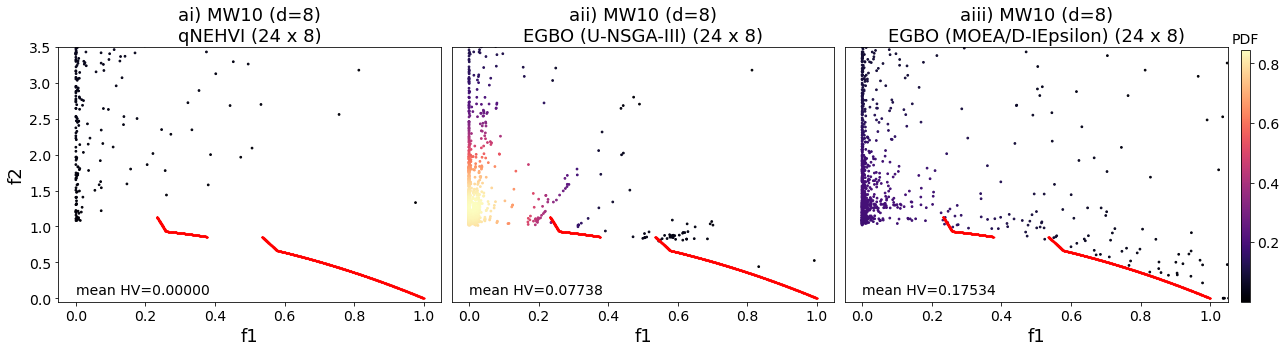

In [17]:
problemname = "MW10"
problem = Problem_MW10
problem1 = get_problem("mw10")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga', 'hybrid_moead']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
        ylist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 3, figsize = (18,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
    [0, 1, 2],
    ['i', 'ii', 'iii']):
    

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    #myarc = mpatches.Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=360, color="blue", lw=0.7, alpha=0.6)
    #ax[i].add_artist(myarc)
    
    #ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, linewidth=1.1, alpha=0.6))
    
    #line1 = [0, 1]
    #line2 = [1, 0]
    #ax[i].plot(line1, line2, marker=',', linestyle='-', color='b', linewidth=0.7, alpha=0.6)
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)    
    
    ax[i].text(0.0, 0.05, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"a{subsub}) {problemname} (d={dimensions})\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)

    ax[i].set_xlim(-0.05, 1.05)
    ax[i].set_ylim(-0.05, 3.50)
    
    ax[i].set_xlabel('f1')
    ax[i].tick_params(axis='y', which='both', left=False, labelleft=False)

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=14)

Text(0.5, 1.0, 'PDF')

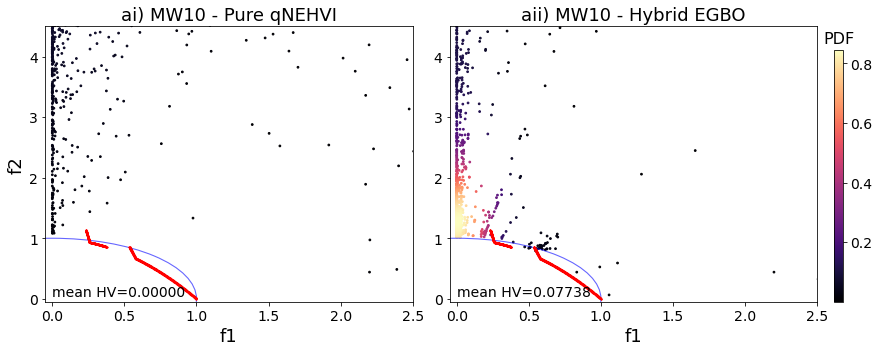

In [9]:
problemname = "MW10"
problem = Problem_MW10
problem1 = get_problem("mw10")
pareto = problem1.pareto_front()    

N_TRIALS = 10
N_BATCH = 24
BATCH_SIZE = 8

hv_list, x_list, y_list, z_list = [], [], [], []

for algo_name in (['qnehvi', 'hybrid_nsga']):
    
    hv = loadtxt(f"{problemname}_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    hv_list.append(hv)
    
    train = loadtxt(f"{problemname}_train_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
    train = train.reshape(N_TRIALS, N_BATCH*BATCH_SIZE + 2*(problem.n_var+1), problem.n_var+problem.n_obj+problem.n_constr)
    
    xlist, ylist = [], []

    for trial in range(N_TRIALS):

        xlist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,0])
        ylist.append(-train[trial][:,-problem.n_obj-problem.n_constr:-problem.n_constr][:,1])

    x = np.array(xlist).reshape(-1)
    y = np.array(ylist).reshape(-1)
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    x_list.append(x)
    y_list.append(y)
    z_list.append(z)
    
fig, ax = plt.subplots(ncols = 2, figsize = (12,5))

norm = plt.Normalize(np.array(z_list).min(), np.array(z_list).max())

for plot_name, i, subsub in zip(
    ['Pure qNEHVI', 'Hybrid EGBO'],
    [0, 1],
    ['i', 'ii']):
    

    ax[i].scatter(x_list[i], y_list[i], c=z_list[i], s=3, norm=norm, cmap='magma')
    
    #myarc = mpatches.Arc((0, 0), 2, 2, angle=0, theta1=0, theta2=360, color="blue", lw=0.7, alpha=0.6)
    #ax[i].add_artist(myarc)
    
    ax[i].add_patch(plt.Circle((0, 0), 1, color='b', fill=False, linewidth=1.1, alpha=0.6))
    
    #line1 = [0, 1]
    #line2 = [1, 0]
    #ax[i].plot(line1, line2, marker=',', linestyle='-', color='b', linewidth=0.7, alpha=0.6)
    
    
    
    ax[i].scatter(pareto[:,0],
                  pareto[:,1], 
                  c="r", s=3, marker=".", alpha=0.8)    
    
    ax[i].text(0.0, 0.05, f"mean HV={hv_list[i].mean(axis=0)[-1]:.5f}", fontsize=14)

    ax[i].set_title(f"a{subsub}) {problemname} - {plot_name}", fontsize=18)

    ax[i].set_xlim(-0.05, 2.50)
    ax[i].set_ylim(-0.05, 4.50)
    
    ax[i].set_xlabel('f1')

    
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

ax[0].set_ylabel('f2')

fig.tight_layout()

sm = ScalarMappable(norm=norm, cmap='magma')
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("PDF", fontsize=16)